In [1]:
file_path = 'data/words.txt'

# Display the first 20 lines for test
with open(file_path, 'r') as file:
    for i in range(20):
        print(file.readline().strip())


#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [2]:
#IMPORTS

from tensorflow.keras.layers import StringLookup
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)                             # Fix NumPy random seed to ensure reproducible random numbers
tf.random.set_seed(42)                         # Fix TensorFlow random seed for reproducible neural network initialization

In [3]:
#DATASET SPLITTING

base_path = "data"
words_list = []

words=open(f"{base_path}/words.txt","r").readlines()
for line in words:
    if line[0]=="#":
        continue
    if line.split(" ")[1]!="err": #We do not need to deal with errored entries.
        words_list.append(line)

length = len(words_list)
print(length)
np.random.shuffle(words_list)


96456


In [4]:
# We will split the dataset into three subsets

# Calculate the split index for training data (90% of total data)
split_idx = int(0.9 * length)

# Split the data into training and temporary test sets
train_samples = words_list[:split_idx]        # First 90% for training
test_samples = words_list[split_idx:]         # Remaining 10% for test/validation

# Further split the test samples into validation and test sets
val_split_idx = int(0.5 * len(test_samples))  # Calculate middle point of test samples
validation_samples = test_samples[:val_split_idx]  # First half for validation
test_samples = test_samples[val_split_idx:]       # Second half for testing

# Verify that the splits maintain all data (no samples lost)
assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

# Print the size of each dataset split
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [5]:
# Define the base path for word images
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    """
    Process samples to extract image paths and corresponding labels.

    Args:
        samples: List of strings containing image information and labels

    Returns:
        tuple: (list of image paths, list of corrected labels)
    """
    paths = []
    corrected_samples = []

    # Iterate through each sample in the dataset
    for (i, file_line) in enumerate(samples):
        # Clean and split the line into components
        line_split = file_line.strip()        # Remove leading/trailing whitespace
        line_split = line_split.split(" ")    # Split line into parts

        # Extract image name and construct path components
        # Format: part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]      # First part of image name
        partII = image_name.split("-")[1]     # Second part of image name

        # Construct full image path
        img_path = os.path.join(
            base_image_path,                  # Base directory
            partI,                            # First level directory
            partI + "-" + partII,            # Second level directory
            image_name + ".png"              # Image file name
        )

        # Only include images that exist and have content
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

# Process each dataset split to get image paths and labels
train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
train_img_paths[0:10]

['data\\words\\e04\\e04-030\\e04-030-04-08.png',
 'data\\words\\k02\\k02-102\\k02-102-05-03.png',
 'data\\words\\a01\\a01-082u\\a01-082u-01-04.png',
 'data\\words\\m01\\m01-000\\m01-000-07-00.png',
 'data\\words\\g01\\g01-031\\g01-031-07-06.png',
 'data\\words\\f07\\f07-081b\\f07-081b-01-06.png',
 'data\\words\\n03\\n03-082\\n03-082-04-03.png',
 'data\\words\\g06\\g06-018c\\g06-018c-04-05.png',
 'data\\words\\g06\\g06-011j\\g06-011j-06-06.png',
 'data\\words\\f04\\f04-024\\f04-024-01-06.png']

In [7]:
train_labels[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [8]:
# Find maximum length and the size of the vocab. in the training data

train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label= label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)
    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)
print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

#Check some label samples
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [9]:
# Clean the validation and the test labels

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label=label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [10]:
# Building the character vocab.

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Integers back to original characters

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [11]:
# Resizing images without distortion

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size = (h,w), preserve_aspect_ratio = True)

    #The amount of padding needed to be done
    pad_height = h-tf.shape(image)[0]
    pad_width = w-tf.shape(image)[1]

    # Padding on both sides

    if pad_height % 2 != 0:
        height = pad_height//2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height//2

    if pad_width % 2 != 0:
        width = pad_width//2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width//2

    image = tf.pad(image, paddings=[(pad_height_top, pad_height_bottom),[pad_width_left, pad_width_right], [0,0],
                                    ],
                   )

    image = tf.transpose(image, perm=[1,0,2])
    image = tf.image.flip_left_right(image)
    return image

In [12]:
# Define global parameters for data processing
batch_size = 64                # Number of samples per batch
padding_token = 99            # Token used for padding sequences
image_width = 128             # Target width for all images
image_height = 32             # Target height for all images

def preprocess_image(image_path, img_size=(image_width, image_height)):
    """
    Load and preprocess an image from path.

    Args:
        image_path: Path to the image file
        img_size: Tuple of (width, height) for resizing
    Returns:
        Preprocessed image tensor
    """
    # Load and decode image
    image = tf.io.read_file(image_path)                # Read image file
    image = tf.image.decode_png(image, 1)              # Decode PNG to grayscale

    # Resize image while maintaining aspect ratio
    image = distortion_free_resize(image, img_size)    # Custom resize function

    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    """
    Convert text label to vector of integers with padding.

    Args:
        label: Text string to vectorize
    Returns:
        Padded vector of integer tokens
    """
    # Convert characters to numbers using char_to_num lookup
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    # Add padding to make all sequences same length
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    """
    Combined preprocessing function for both image and label.

    Args:
        image_path: Path to image file
        label: Text label
    Returns:
        Dictionary containing processed image and label
    """
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    """
    Create and configure TensorFlow dataset for training.

    Args:
        image_paths: List of image file paths
        labels: List of corresponding labels
    Returns:
        Configured TensorFlow dataset
    """
    # Create dataset from paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )

    # Configure dataset for performance
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)           # Prefetch next batch

In [13]:
# Prepare tf.data.Dataset objects

train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

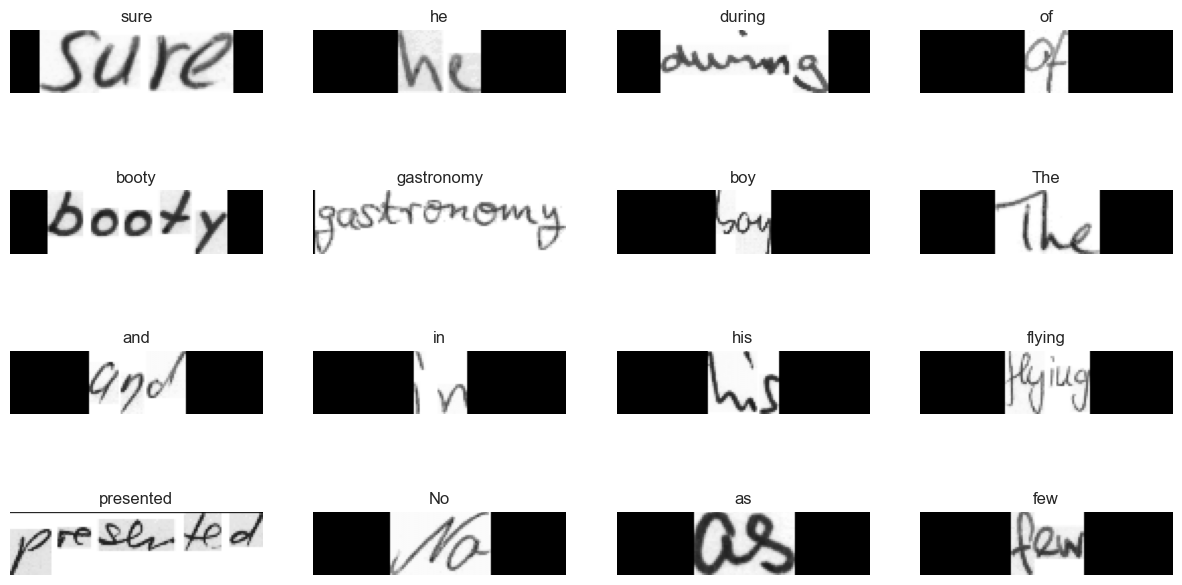

In [14]:
# Visualize some samples

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label != padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


In [ ]:
# MODEL

In [16]:
class CTCLayer(keras.layers.Layer):
    """Custom layer for CTC (Connectionist Temporal Classification) loss calculation"""
    def __init__(self, name=None):
        super().__init__(name=name)
        # Initialize CTC loss function from Keras backend
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Calculate necessary lengths for CTC loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")     # Batch size
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # Length of predictions
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")  # Length of labels

        # Create tensors of ones with appropriate shapes
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Calculate CTC loss and add it to the layer
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred  # Return predictions for inference

def build_model():
    """Builds and returns the complete handwriting recognition model"""
    # Define model inputs
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First Convolutional Block
    x = keras.layers.Conv2D(
        32,                            # 32 filters
        (3, 3),                        # 3x3 kernel size
        activation="relu",             # ReLU activation
        kernel_initializer="he_normal", # He initialization for weights
        padding="same",                # Same padding to maintain dimensions
        name="Conv1"
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)  # 2x2 pooling

    # Second Convolutional Block
    x = keras.layers.Conv2D(
        64,                            # 64 filters
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2"
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Reshape layer to prepare for RNN
    # New shape calculation based on pooling operations
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # Dense layer for feature processing
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)   # Dropout for regularization

    # Bidirectional LSTM layers for sequence processing
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # Output Dense layer
    # Vocabulary size + 2 for CTC blank and unknown tokens
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2,
        activation="softmax",
        name="dense2"
    )(x)

    # Add CTC layer for loss calculation
    ctc_layer = CTCLayer(name="ctc_loss")
    output = ctc_layer(labels, x)

    # Create and compile model
    model = keras.models.Model(
        inputs=[input_img, labels],
        outputs=output,
        name="handwriting_recognizer"
    )

    # Configure optimizer
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

# Create model instance
model = build_model()

# Display model architecture
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 16,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 64, 16,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 8, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 32, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 32, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 81)    │     10,449 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 81)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,081 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Split the validation images and their labels

validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [18]:
def calculate_edit_distance(labels, predictions):
    """
    Calculate the edit distance between predicted and actual labels.

    Args:
        labels: True labels from the dataset
        predictions: Model predictions
    Returns:
        Mean edit distance across the batch
    """
    # Convert dense labels to sparse tensors for edit distance calculation
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Decode CTC predictions to get actual character sequences
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]  # Input lengths for CTC decoder
    predictions_decoded = keras.backend.ctc_decode(
        predictions,
        input_length=input_len,
        greedy=True                    # Use greedy decoding strategy
    )[0][0][:, :max_len]              # Limit to maximum sequence length

    # Convert decoded predictions to sparse tensors
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded),
        dtype=tf.int64
    )

    # Calculate edit distances between predictions and labels
    # normalize=False means we get absolute number of edits needed
    edit_distances = tf.edit_distance(
        sparse_predictions,
        sparse_labels,
        normalize=False
    )

    # Return mean edit distance across the batch
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    """
    Callback to monitor edit distance metric during training.

    The edit distance measures how many operations (insertions, deletions, substitutions)
    are needed to transform the predicted text into the true text.
    """
    def __init__(self, pred_model):
        """
        Initialize callback with prediction model.

        Args:
            pred_model: Model used for making predictions
        """
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        """
        Calculate and display mean edit distance at the end of each epoch.

        Args:
            epoch: Current epoch number
            logs: Training logs (unused)
        """
        edit_distances = []

        # Calculate edit distance for each batch in validation dataset
        for batch in validation_ds:
            images = batch["image"]
            labels = batch["label"]
            # Make predictions on current batch
            predictions = self.prediction_model.predict(images, verbose=0)
            # Calculate and store edit distance for batch
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        # Calculate and display mean edit distance across all batches
        mean_edit_distance = np.mean(edit_distances)
        print(f"\nMean edit distance for epoch {epoch + 1}: {mean_edit_distance:.4f}")

In [19]:
# Check dataset structure
for batch in train_ds.take(1):
    print("Dataset batch structure:", batch.keys())
    for key, value in batch.items():
        print(f"{key} shape:", value.shape)


Dataset batch structure: dict_keys(['image', 'label'])
image shape: (64, 128, 32, 1)
label shape: (64, 21)


In [ ]:
#TRAINING

In [28]:
import seaborn as sns
import pandas as pd
# Number of epochs for training
epochs = 50

# Build the main model
model = build_model()

# Print model input and output details
print("\nModel inputs:")
for input_layer in model.inputs:
    print(input_layer.name, input_layer.shape)

print("\nModel outputs:")
for output_layer in model.outputs:
    print(output_layer.name, output_layer.shape)

# Create prediction model
prediction_model = keras.models.Model(
    inputs=model.inputs[0],  # The image input tensor
    outputs=model.get_layer("dense2").output
)

# Verify prediction model structure
print("\nPrediction model:")
print("Input shape:", prediction_model.input_shape)
print("Output shape:", prediction_model.output_shape)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[EditDistanceCallback(prediction_model)]
)

# Save the models
try:
    # Save the main model
    model.save('handwriting_recognition_model.keras')
    print("Main model saved successfully as 'handwriting_recognition_model'")

    # Save the prediction model
    prediction_model.save('handwriting_prediction_model.keras')
    print("Prediction model saved successfully as 'handwriting_prediction_model'")

    # Save the training history
    import json
    history_dict = history.history
    with open('training_history.json', 'w') as f:
        json.dump(history_dict, f)
    print("Training history saved as 'training_history.json'")

    # Save the character mappings
    np.save('char_to_num_vocab.npy', char_to_num.get_vocabulary())
    print("Character vocabulary saved as 'char_to_num_vocab.npy'")

except Exception as e:
    print(f"Error saving models: {str(e)}")

# Create figure with 3 subplots
plt.figure(figsize=(18, 6))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot edit distance if available
if 'edit_distance' in history.history:
    plt.subplot(1, 3, 2)
    plt.plot(history.history['edit_distance'], label='Edit Distance')
    plt.title('Edit Distance')
    plt.xlabel('Epoch')
    plt.ylabel('Distance')
    plt.legend()

# Add violin plot
plt.subplot(1, 3, 3)
data = {
    'Training Loss': history.history['loss']
}
if 'val_loss' in history.history:
    data['Validation Loss'] = history.history['val_loss']

df = pd.DataFrame(data)
sns.violinplot(data=df)
plt.title('Loss Distribution')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\nTraining completed and all artifacts saved!")


Model inputs:
image (None, 128, 32, 1)
label (None, None)

Model outputs:
keras_tensor_112 (None, 32, 81)

Prediction model:
Input shape: (None, 128, 32, 1)
Output shape: (None, 32, 81)
Epoch 1/50
   2/1357 ━━━━━━━━━━━━━━━━━━━━ 11:34 513ms/step - loss: 7769.2217

KeyboardInterrupt: 

In [25]:
#TESTING

Starting model testing...


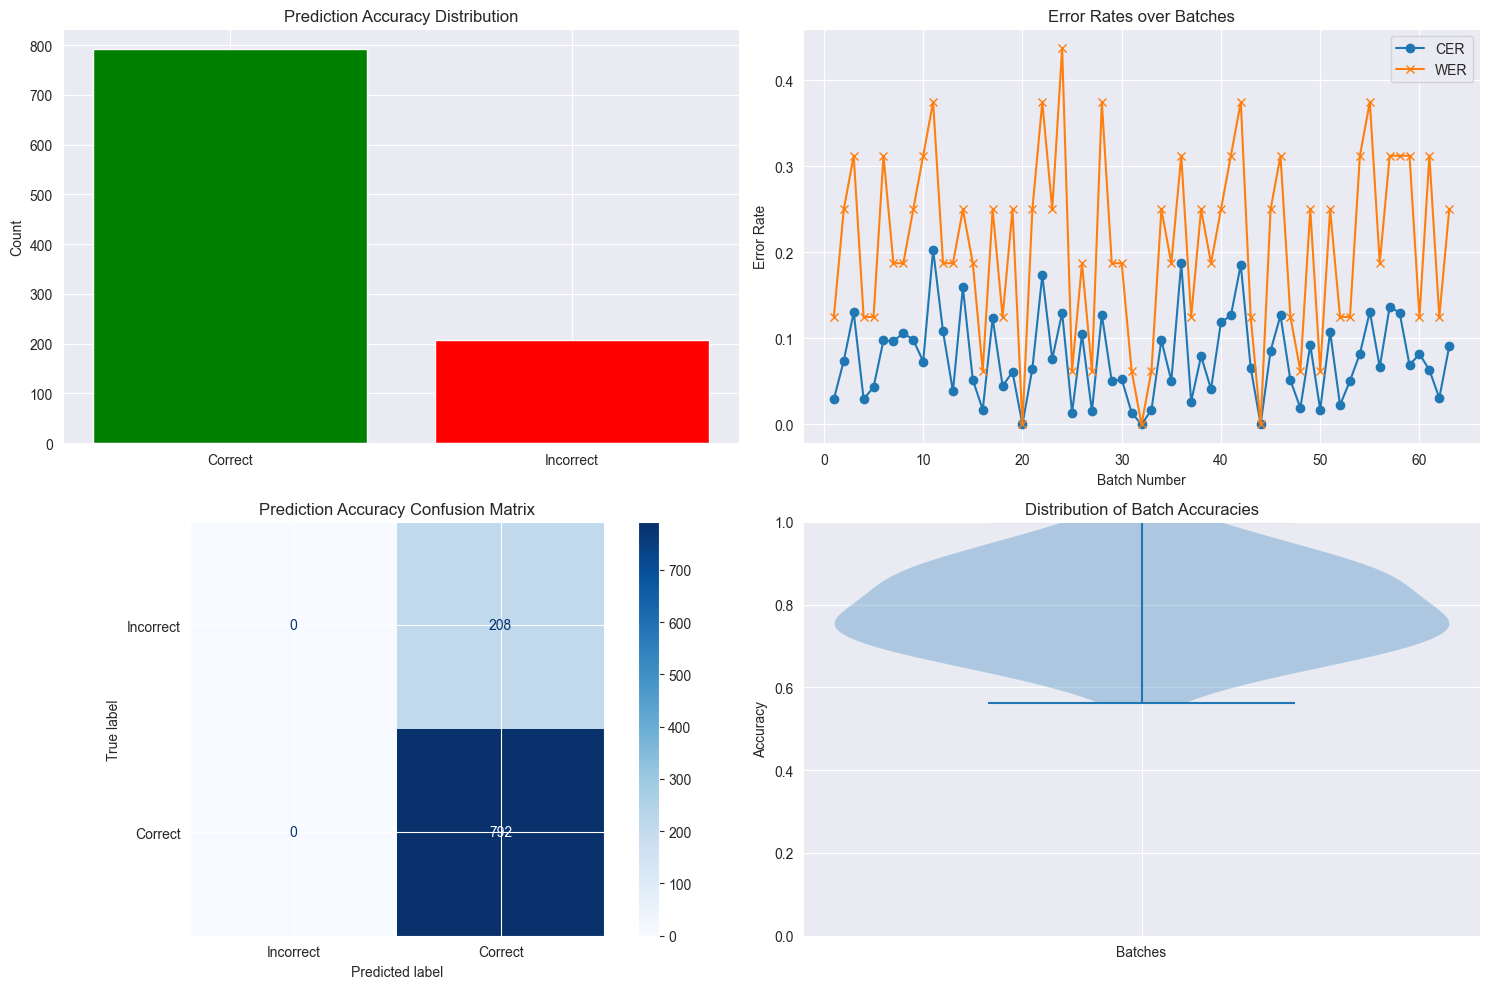


Test Results:
Total images processed: 1000
Correct predictions: 792
Accuracy: 79.20%
Character Error Rate (CER): 0.0772
Word Error Rate (WER): 0.2080

Testing completed successfully!


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from jiwer import wer, cer
from tensorflow import keras
import json

# Constants
image_width = 128
image_height = 32
max_len = 21

# Custom CTC Layer (needed for loading the model)
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Determine the batch size
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        # Calculate input and label lengths
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        # Create input and label length tensors
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        # Compute the loss and add it to the layer
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred


# Function to load models and character vocabularies
def load_models_and_vocabularies():
    """Load saved models and vocabularies"""
    try:
        # Load models
        prediction_model = keras.models.load_model('handwriting_prediction_model.keras')

        # Load vocabulary
        char_vocab = np.load('char_to_num_vocab.npy', allow_pickle=True)

        # Recreate character mappings
        char_to_num = keras.layers.StringLookup(vocabulary=list(char_vocab), mask_token=None)
        num_to_char = keras.layers.StringLookup(
            vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

        return prediction_model, char_to_num, num_to_char

    except Exception as e:
        print(f"Error loading models and vocabularies: {e}")
        return None, None, None

def distortion_free_resize(image, img_size):
    """Resize images without distortion"""
    w, h = img_size
    # Resize the image
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
     # Calculate padding dimensions
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[(pad_height_top, pad_height_bottom),
                 (pad_width_left, pad_width_right),
                 (0, 0)]
    )
    # Adjust orientation and return the resized image
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

# Function to decode predictions into readable text
def decode_batch_predictions(pred, num_to_char):
    """Decode model predictions"""
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    try:
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
        output_text = []
        for res in results:
            res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
            if len(res.numpy()) > 0:
                res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
            else:
                res = ""
            output_text.append(res)
        return output_text
    except Exception as e:
        print(f"Error in decoding: {e}")
        return ["" for _ in range(pred.shape[0])]

# Function to test the model using images listed in a CSV file
def test_images_from_csv(csv_path, prediction_model, num_to_char):
    """Test the model on images listed in a CSV file"""
    # Read CSV file
    test_data = pd.read_csv(csv_path, header=None, names=['image_path', 'label'])

    # Initialize metrics
    true_match = 0
    total_processed = 0
    batch_size = 16
    pred_texts_all = []
    true_labels_all = []
    batch_cer = []
    batch_wer = []
    batch_numbers = []

    # Process images in batches
    for batch_start in range(0, len(test_data), batch_size):
        batch_end = min(batch_start + batch_size, len(test_data))
        batch_data = test_data[batch_start:batch_end]

        batch_images = []
        for img_path in batch_data['image_path']:
            try:
                image = tf.io.read_file(img_path)
                image = tf.image.decode_png(image, 1)
                image = distortion_free_resize(image, (image_width, image_height))
                image = tf.cast(image, tf.float32) / 255.0
                batch_images.append(image)
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

        if not batch_images:
            continue

        batch_images = tf.stack(batch_images)
        preds = prediction_model.predict(batch_images, verbose=0)
        pred_texts = decode_batch_predictions(preds, num_to_char)

        # Track predictions and metrics
        pred_texts_all.extend(pred_texts)
        true_labels_all.extend(batch_data['label'].tolist())

        # Calculate batch metrics
        cer_batch = cer(batch_data['label'].tolist(), pred_texts)
        wer_batch = wer(batch_data['label'].tolist(), pred_texts)
        batch_cer.append(cer_batch)
        batch_wer.append(wer_batch)
        batch_numbers.append(batch_start // batch_size + 1)

        # Count correct predictions
        for pred_text, true_label in zip(pred_texts, batch_data['label']):
            if pred_text.strip() == str(true_label).strip():
                true_match += 1
            total_processed += 1

    # Visualizations
    plot_results(true_match, total_processed, batch_numbers, batch_cer, batch_wer,
                pred_texts_all, true_labels_all)

    return true_match, total_processed

def plot_results(true_match, total_processed, batch_numbers, batch_cer, batch_wer,
                pred_texts_all, true_labels_all):
    """Plot test results including violin plot"""
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))

    # Original plots in a 2x2 grid
    plt.subplot(2, 2, 1)
    # Accuracy Distribution
    correct_preds = true_match
    incorrect_preds = total_processed - true_match
    plt.bar(['Correct', 'Incorrect'], [correct_preds, incorrect_preds], color=['green', 'red'])
    plt.title("Prediction Accuracy Distribution")
    plt.ylabel("Count")

    # Error Rates Over Batches
    plt.subplot(2, 2, 2)
    plt.plot(batch_numbers, batch_cer, label="CER", marker='o')
    plt.plot(batch_numbers, batch_wer, label="WER", marker='x')
    plt.title("Error Rates over Batches")
    plt.xlabel("Batch Number")
    plt.ylabel("Error Rate")
    plt.legend()

    # Confusion Matrix
    plt.subplot(2, 2, 3)
    y_true = [1 if pred.strip() == true.strip() else 0
              for pred, true in zip(pred_texts_all, true_labels_all)]
    y_pred = [1] * len(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"])
    disp.plot(ax=plt.gca(), cmap=plt.cm.Blues)
    plt.title("Prediction Accuracy Confusion Matrix")

    # Add Violin Plot
    plt.subplot(2, 2, 4)
    # Calculate accuracy per batch
    batch_size = 16
    batch_accuracies = []
    for i in range(0, len(pred_texts_all), batch_size):
        batch_pred = pred_texts_all[i:i+batch_size]
        batch_true = true_labels_all[i:i+batch_size]
        batch_acc = sum(1 for p, t in zip(batch_pred, batch_true)
                       if p.strip() == str(t).strip()) / len(batch_pred)
        batch_accuracies.append(batch_acc)

    # Create violin plot
    plt.violinplot(batch_accuracies, positions=[1])
    plt.title("Distribution of Batch Accuracies")
    plt.ylabel("Accuracy")
    plt.xticks([1], ['Batches'])
    plt.ylim(0, 1)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print Statistics
    print("\nTest Results:")
    print(f"Total images processed: {total_processed}")
    print(f"Correct predictions: {true_match}")
    print(f"Accuracy: {(true_match/total_processed)*100:.2f}%")
    print(f"Character Error Rate (CER): {cer(true_labels_all, pred_texts_all):.4f}")
    print(f"Word Error Rate (WER): {wer(true_labels_all, pred_texts_all):.4f}")

def main():
    """Main function to run the testing"""
    # Load models and vocabularies
    prediction_model, char_to_num, num_to_char = load_models_and_vocabularies()

    if prediction_model is None:
        return

    # Run tests
    try:
        print("Starting model testing...")
        true_matches, total = test_images_from_csv('updated_test_values.csv',
                                                 prediction_model, num_to_char)
        print("\nTesting completed successfully!")
    except Exception as e:
        print(f"An error occurred during testing: {str(e)}")

if __name__ == "__main__":
    main()

Starting model testing...


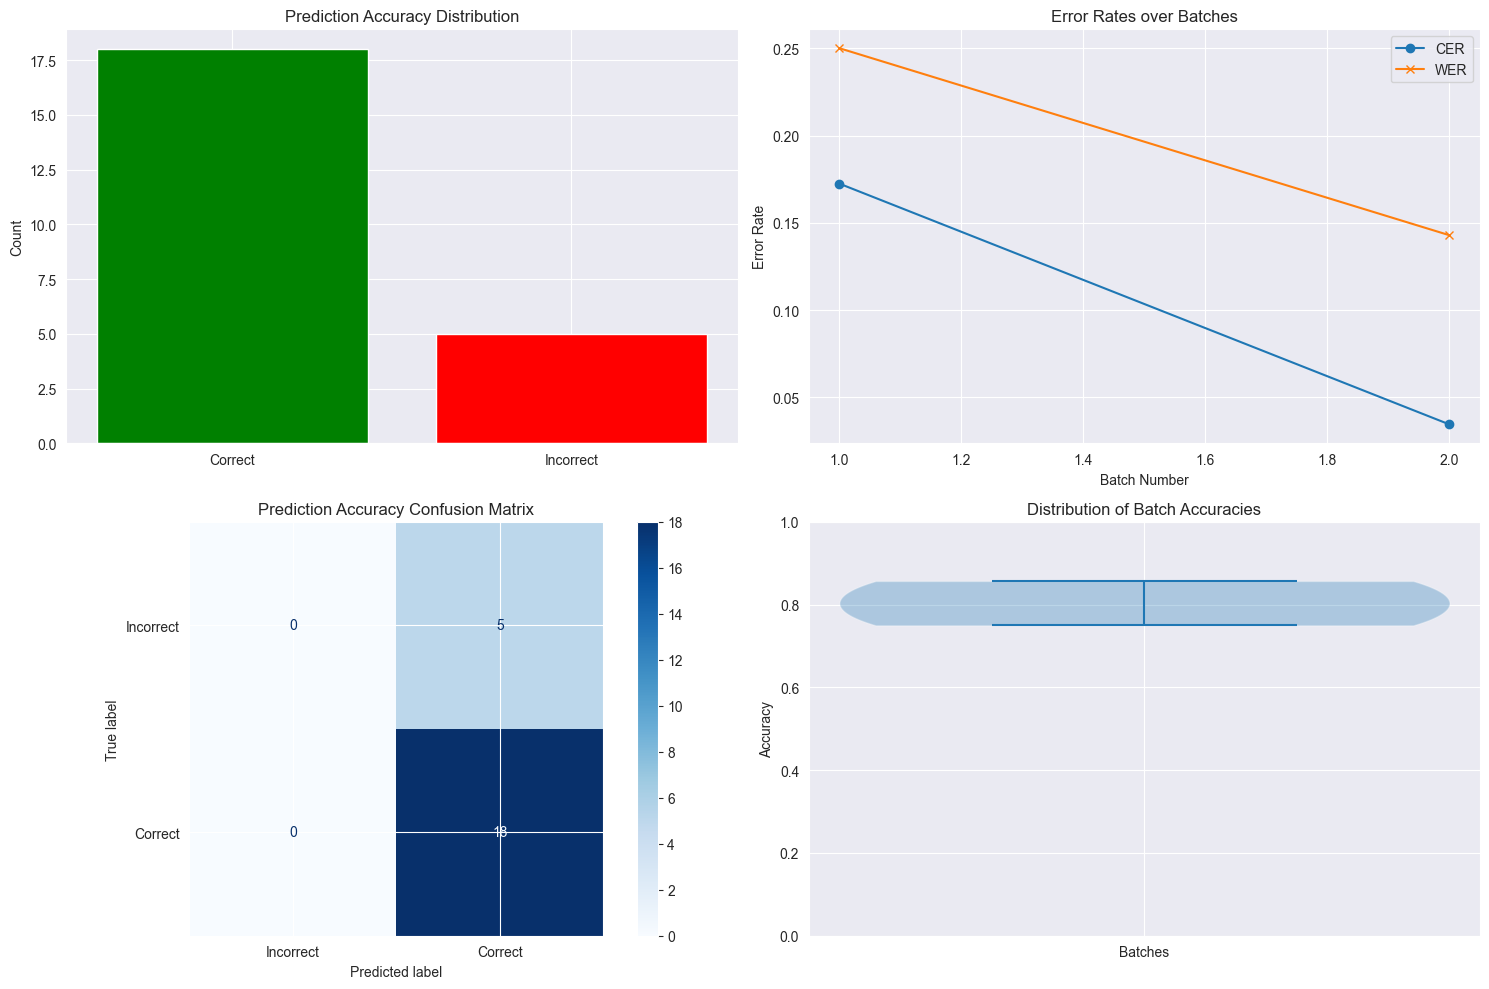


Test Results:
Total images processed: 23
Correct predictions: 18
Accuracy: 78.26%
Character Error Rate (CER): 0.1264
Word Error Rate (WER): 0.2174

Testing completed successfully!


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from jiwer import wer, cer
from tensorflow import keras
import json

# Constants
image_width = 128
image_height = 32
max_len = 21

# Custom CTC Layer (needed for loading the model)
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Determine the batch size
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        # Calculate input and label lengths
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        # Create input and label length tensors
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        # Compute the loss and add it to the layer
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred


# Function to load models and character vocabularies
def load_models_and_vocabularies():
    """Load saved models and vocabularies"""
    try:
        # Load models
        prediction_model = keras.models.load_model('handwriting_prediction_model.keras')

        # Load vocabulary
        char_vocab = np.load('char_to_num_vocab.npy', allow_pickle=True)

        # Recreate character mappings
        char_to_num = keras.layers.StringLookup(vocabulary=list(char_vocab), mask_token=None)
        num_to_char = keras.layers.StringLookup(
            vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

        return prediction_model, char_to_num, num_to_char

    except Exception as e:
        print(f"Error loading models and vocabularies: {e}")
        return None, None, None

def distortion_free_resize(image, img_size):
    """Resize images without distortion"""
    w, h = img_size
    # Resize the image
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
     # Calculate padding dimensions
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[(pad_height_top, pad_height_bottom),
                 (pad_width_left, pad_width_right),
                 (0, 0)]
    )
    # Adjust orientation and return the resized image
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

# Function to decode predictions into readable text
def decode_batch_predictions(pred, num_to_char):
    """Decode model predictions"""
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    try:
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
        output_text = []
        for res in results:
            res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
            if len(res.numpy()) > 0:
                res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
            else:
                res = ""
            output_text.append(res)
        return output_text
    except Exception as e:
        print(f"Error in decoding: {e}")
        return ["" for _ in range(pred.shape[0])]

# Function to test the model using images listed in a CSV file
def test_images_from_csv(csv_path, prediction_model, num_to_char):
    """Test the model on images listed in a CSV file"""
    # Read CSV file
    test_data = pd.read_csv(csv_path, header=None, names=['image_path', 'label'])

    # Initialize metrics
    true_match = 0
    total_processed = 0
    batch_size = 16
    pred_texts_all = []
    true_labels_all = []
    batch_cer = []
    batch_wer = []
    batch_numbers = []

    # Process images in batches
    for batch_start in range(0, len(test_data), batch_size):
        batch_end = min(batch_start + batch_size, len(test_data))
        batch_data = test_data[batch_start:batch_end]

        batch_images = []
        for img_path in batch_data['image_path']:
            try:
                image = tf.io.read_file(img_path)
                image = tf.image.decode_png(image, 1)
                image = distortion_free_resize(image, (image_width, image_height))
                image = tf.cast(image, tf.float32) / 255.0
                batch_images.append(image)
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

        if not batch_images:
            continue

        batch_images = tf.stack(batch_images)
        preds = prediction_model.predict(batch_images, verbose=0)
        pred_texts = decode_batch_predictions(preds, num_to_char)

        # Track predictions and metrics
        pred_texts_all.extend(pred_texts)
        true_labels_all.extend(batch_data['label'].tolist())

        # Calculate batch metrics
        cer_batch = cer(batch_data['label'].tolist(), pred_texts)
        wer_batch = wer(batch_data['label'].tolist(), pred_texts)
        batch_cer.append(cer_batch)
        batch_wer.append(wer_batch)
        batch_numbers.append(batch_start // batch_size + 1)

        # Count correct predictions
        for pred_text, true_label in zip(pred_texts, batch_data['label']):
            if pred_text.strip() == str(true_label).strip():
                true_match += 1
            total_processed += 1

    # Visualizations
    plot_results(true_match, total_processed, batch_numbers, batch_cer, batch_wer,
                pred_texts_all, true_labels_all)

    return true_match, total_processed

def plot_results(true_match, total_processed, batch_numbers, batch_cer, batch_wer,
                pred_texts_all, true_labels_all):
    """Plot test results including violin plot"""
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))

    # Original plots in a 2x2 grid
    plt.subplot(2, 2, 1)
    # Accuracy Distribution
    correct_preds = true_match
    incorrect_preds = total_processed - true_match
    plt.bar(['Correct', 'Incorrect'], [correct_preds, incorrect_preds], color=['green', 'red'])
    plt.title("Prediction Accuracy Distribution")
    plt.ylabel("Count")

    # Error Rates Over Batches
    plt.subplot(2, 2, 2)
    plt.plot(batch_numbers, batch_cer, label="CER", marker='o')
    plt.plot(batch_numbers, batch_wer, label="WER", marker='x')
    plt.title("Error Rates over Batches")
    plt.xlabel("Batch Number")
    plt.ylabel("Error Rate")
    plt.legend()

    # Confusion Matrix
    plt.subplot(2, 2, 3)
    y_true = [1 if pred.strip() == true.strip() else 0
              for pred, true in zip(pred_texts_all, true_labels_all)]
    y_pred = [1] * len(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"])
    disp.plot(ax=plt.gca(), cmap=plt.cm.Blues)
    plt.title("Prediction Accuracy Confusion Matrix")

    # Add Violin Plot
    plt.subplot(2, 2, 4)
    # Calculate accuracy per batch
    batch_size = 16
    batch_accuracies = []
    for i in range(0, len(pred_texts_all), batch_size):
        batch_pred = pred_texts_all[i:i+batch_size]
        batch_true = true_labels_all[i:i+batch_size]
        batch_acc = sum(1 for p, t in zip(batch_pred, batch_true)
                       if p.strip() == str(t).strip()) / len(batch_pred)
        batch_accuracies.append(batch_acc)

    # Create violin plot
    plt.violinplot(batch_accuracies, positions=[1])
    plt.title("Distribution of Batch Accuracies")
    plt.ylabel("Accuracy")
    plt.xticks([1], ['Batches'])
    plt.ylim(0, 1)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print Statistics
    print("\nTest Results:")
    print(f"Total images processed: {total_processed}")
    print(f"Correct predictions: {true_match}")
    print(f"Accuracy: {(true_match/total_processed)*100:.2f}%")
    print(f"Character Error Rate (CER): {cer(true_labels_all, pred_texts_all):.4f}")
    print(f"Word Error Rate (WER): {wer(true_labels_all, pred_texts_all):.4f}")

def main():
    """Main function to run the testing"""
    # Load models and vocabularies
    prediction_model, char_to_num, num_to_char = load_models_and_vocabularies()

    if prediction_model is None:
        return

    # Run tests
    try:
        print("Starting model testing...")
        true_matches, total = test_images_from_csv('val.csv',
                                                 prediction_model, num_to_char)
        print("\nTesting completed successfully!")
    except Exception as e:
        print(f"An error occurred during testing: {str(e)}")

if __name__ == "__main__":
    main()